In [1]:
import gym
import time
from functools import reduce
import argparse
import collections
import numpy as np
import pandas as pd
from gym import spaces
import matplotlib.pylab as plt

## 问题描述

使用强化学习，寻找能够使得目标函数$y = x^{2}$值最小的解$x$，

## 创建环境模型



In [2]:
from IPython.display import clear_output
class OptiFunctionEnv(gym.Env):
    def __init__(self):
        super(OptiFunctionEnv, self).__init__()
        """
        描述: y = x^{2} 的⽬标函数，希望求得能够使得⽬标函数最⼩的x。
        在初始化函数中主要需要设置状态空间和动作空间。
        """
        self.obs_bound = np.array([5])  # 观测空间只有一个，边界定义为-5到5。
        # 设置状态空间范围：-high到high，类型为int32
        self.observation_space = spaces.Box(-self.obs_bound, self.obs_bound, dtype=np.int32)
        
        self.action_space = spaces.Discrete(2) # 设置动作空间：0, 1。分别表示为向左向右。
        
        self.state = None
        self.episode_limit = 20  # episode的最大长度
        self.episode_cur = 0  # episode的当前位置。
    
    def func(self, x):
        return np.power(x, 2)
    
    def step(self, action):
        """
        给定动作，在环境中进⾏状态转移
        """
        err_msg = "{} ({}) invalid".format(action, type(action))
        assert self.action_space.contains(action), err_msg
        
        self.episode_cur += 1  # episode的当前位置加1。
        
        pre_state = self.state
        self.state += 1 if action else -1
        # done = True if not self.observation_space.contains(self.state) or \
        #                                     self.episode_cur >= self.episode_limit else False
        done = bool(self.state < -self.obs_bound or self.state > self.obs_bound or self.episode_cur >= 20)
        
        if done:
            reward = -(self.func(self.state) - self.func(pre_state))
        else:
            reward = -(self.func(self.state) - self.func(pre_state))
        return self.state, reward, done, {}
    
    def reset(self):
        """
        初始化环境状态
        """
        self.episode_cur = 0  # 初始化episode当前位置为0。
        
        self.state = np.random.choice([self.observation_space.low[0], self.observation_space.high[0]])
        
        return self.state
    
    def render(self, mode='human'):
        clear_output(True)
        x = np.linspace(-self.obs_bound, self.obs_bound, 100) 
        y = [self.func(i) for i in x]
        plt.cla()
        plt.plot(x, y, 'r', linewidth=2)
        plt.scatter(self.state, self.func(self.state), linewidth=10)
        plt.title("Find the solution corresponding to the minimum objective value")
        plt.pause(0.1)
    
    def close(self):
        pass

## 设置经验池

In [3]:
import random
import numpy as np

class ReplayBuffer(object):
    def __init__(self, size):
        """
        创建经验回访池
        ----------
        参数：size: int类型，描述经验回放池的最大容量。
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        """
        返回经验池的当前容量大小。
        """
        return len(self._storage)

    def push(self, state, action, reward, next_state, done):
        """
        将观测、动作、奖励、下一个状态、是否结束此次episode压缩进当前经验池。
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        """
        依据索引idxes将数据转换成np.array格式。
        """
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """
        采样一个batch的数据。
        ----------
        参数：batch_size: int类型，需要采样多少数据。
        -------
        返回数据：
        obs_batch: np.array格式，一个batch的观测。
        act_batch: np.array格式，给定一个batch观测下选取的一个batch的动作。
        rew_batch: np.array格式，执行一个batch动作下，得到的一个batch的奖励。
        next_obs_batch: np.array格式，执行一个batch动作下，得到的一个batch的下一个状态。
        done_mask: np.array格式，如果episode结束，done_mask[i] = 1 否则done_mask[i] = 0.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

## 构建智能体

In [4]:
class Agent(object):
    def __init__(self, env, exp_buffer, args):
        """
        初始化智能体
        :param env:
        :param exp_buffer:
        :param args:
        """
        self.env = env
        self.exp_buffer = exp_buffer
        self.q_table = self.build_model()
        self.args = args
    
    def build_model(self):
        """
        构建智能体模型
         :return:
         """
        obs_index = list(range(self.env.observation_space.low[0], self.env.observation_space.high[0] + 1))
        q_table = pd.DataFrame(np.random.random((len(obs_index), self.env.action_space.n)), obs_index,
        list(range(self.env.action_space.n)))
        return q_table
    
    def choose_action(self, state):
        """
        根据环境观测值选择动作的机制
        :param state:
        :return:
        """
        state_action = self.q_table.loc[state, :]
        if np.random.uniform() > self.args.epsilon or (state_action == 0).all():
            action_name = np.random.choice(self.q_table.columns.values)
        else:
            action_name = state_action.idxmax()
        return action_name
    
    def store_transition(self, state, action, r, state_next, done):
        """
        存储轨迹
        :param state:
        :param action:
        :param r:
        :param done:
        :param state_next:
        :return:
        """
        # exp = Experience(state, action, r, done, state_next)
        self.exp_buffer.push(state, action, r, state_next, done)
        
    def learn(self):
        """
        更新智能体模型
        """
        buffer = self.exp_buffer.sample(batch_size=self.args.batch_size)
        batch_state, batch_action, batch_r, batch_next_state, batch_done = buffer
        
        for idx, state in enumerate(batch_state):
            expected_q_value = batch_r[idx] + self.args.gamma * self.q_table.iloc[batch_next_state[idx], :].max() * (1 - batch_done[idx])
            current_q_value = self.q_table.iloc[batch_state[idx], batch_action[idx]]
            delta = expected_q_value - current_q_value
            self.q_table.loc[batch_state[idx], batch_action[idx]] += self.args.lr * delta

In [5]:
def main():
    parser = argparse.ArgumentParser(description="The parameter of Q-Learning")
    parser.add_argument("--replay_size", type=int, help="maximum capacity of the buffer", default=10000)
    parser.add_argument("--gamma", type=float, help="gamma value used for Bellman approximation", default=0.95)
    parser.add_argument("--lr", type=float, help="learning rate used in the Adam optimizer", default=0.1)
    parser.add_argument("--epsilon", type=float, help="epsilon for greedy", default=0.9)
    parser.add_argument("--batch_size", type=int, help="Batch Size for train", default=4)
    args = parser.parse_args(args=[])
                    
    buffer = ReplayBuffer(size=args.replay_size)
    env = OptiFunctionEnv()
    agent = Agent(env, buffer, args)
    
    EpisodeSumReward = []
    for epoch in range(15):
        state, done = env.reset(), False # 1. 获取初始状态信息
        episode_r = []
        while not done:
            env.render()
            action = agent.choose_action(state) # 2. 依据状态选择动作
            state_next, r, done, info = env.step(action) # 3. 依据动作更新环境状态
            agent.store_transition(state, action, r, state_next, done)
            agent.learn() # 4. 智能体进⾏学习
            if not done:
                state = state_next # 5. 更新状态
            episode_r.append(r)
        print("epoch: {} | len_ep_r: {} | avg_r: {}".format(epoch, len(episode_r), \
                                                            np.sum(episode_r) / len(episode_r)))
        EpisodeSumReward.append(np.sum(episode_r))
    env.close()
    plt.plot(EpisodeSumReward)
    plt.title("EpisodeSumReward")
    plt.show()

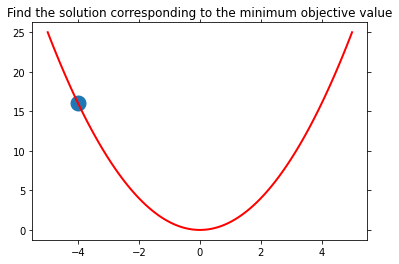

epoch: 14 | len_ep_r: 20 | avg_r: 0.8


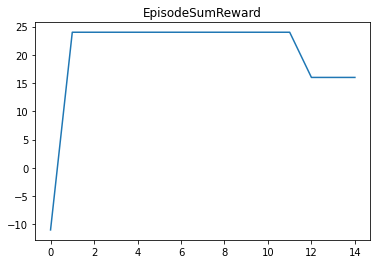

In [6]:
if __name__ == '__main__':
    main()